In [20]:
from numpy import *; from matplotlib.pyplot import *
import sys; sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/'); import os
import predefined as pd; import fileread as fr
import pickle
from scipy.signal import fftconvolve; from scipy.optimize import curve_fit
import time

def fierz_fit(X,N,b):
    '''X is trutharray, w(b=0), and w(b=1)
    NOTES: this assumes the data has been binned according to some set of bins B
           trutharray = bins where this is to fit
           w must be binned just as data to which this is fitting '''
    trutharray=X[0].astype(bool)
    w0,w1=X[1:3]
    return N*(w0[trutharray] + b*(w1[trutharray]-w0[trutharray]))

path='/home/noah/Desktop/large_analysis/zeck_simulation/ca_small_set/'
b0,b1=load(path+'45Ca_b0.npy'),load(path+'45Ca_b1.npy')
b0,b1=pd.sim_restructure(b0),pd.sim_restructure(b1)

fb0,fb1=pd.sim_comb_single_pixel(b0),pd.sim_comb_single_pixel(b1)
b0,fb0=b0.view(recarray),fb0.view(recarray)
b1,fb1=b1.view(recarray),fb1.view(recarray)


### all_runs_w_osc.npy can be loaded to skip this cell

In [9]:
import time
path='/home/noah/Desktop/large_analysis/ca_analysis/cur_data/multi_pixel/'
window=100
runs=[run for run in os.listdir(path) if run.endswith('_window-'+str(window)+'.npy')]
runs.sort()
run=runs[0]
d=np.load(path+run)
print(len(d))

thresh=50 #    ENERGY THRESHOLD FOR SPECTRA


for run in runs[1:]:
    try:
        beg=time.time()    
        temp=np.load(path+run)
        d=np.concatenate((d,temp))
        print('\rfinished run :'+str(run)+' in {:0.2f}'.format(time.time()-beg),end='')
        sys.stdout.flush()
    except TypeError:
        print('\n',run)
        break
del temp
d=d.view(recarray)

566233
finished run :Run_99_window-100.npy in 1.059

1.0027440712543836


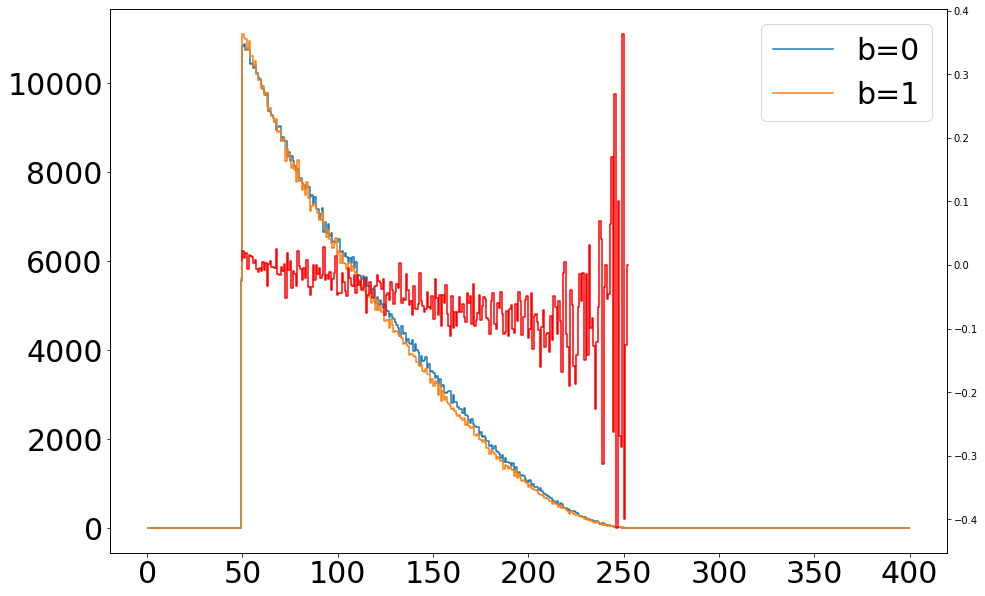

In [38]:
fs=30
temp=b0.copy()
trutharray=np.zeros_like(b0,dtype=bool)

bdchs=[11,35]
for bdch in bdchs:
    bd,ch=int(bdch/8),int(bdch%8)
    trutharray+=(temp.board==bd)*(temp.channel==ch)
trutharray*=(temp.energy>thresh)
temp=temp[trutharray]
sb0=pd.sim_comb_single_pixel(temp)

temp=b1.copy()
trutharray=np.zeros_like(b1,dtype=bool)
for bdch in bdchs:
    bd,ch=int(bdch/8),int(bdch%8)
    trutharray+=(temp.board==bd)*(temp.channel==ch)
trutharray*=(temp.energy>thresh)
temp=temp[trutharray]
sb1=pd.sim_comb_single_pixel(temp)

del temp

sb0,sb1=sb0.view(recarray),sb1.view(recarray)


figure(figsize=(15,10))

sh0,b=histogram(sb0.energy,bins=500,range=[0,400])
sh1,b=histogram(sb1.energy,bins=500,range=[0,400])
fh0=histogram(fb0.energy,bins=500,range=[0,400])[0]
fh1=histogram(fb1.energy,bins=500,range=[0,400])[0]
b0b1_norm=sum(fh0)/sum(fh1)
b=pd.cbins(b)

sh0,sh1=sh0.astype(float),sh1.astype(float)
# norm=max(h[b>0])/max(sh[b>00])

plot(b,sh0,ds='steps',label='b=0')
plot(b,sh1*b0b1_norm,ds='steps',label='b=1')

tick_params(labelsize=fs)
legend(fontsize=fs)

twinx()
trutharray=(sh1>0)*(sh0>0)
plot(b[trutharray],(sh1-sh0)[trutharray]/sh0[trutharray],c='r',ds='steps')

print(b0b1_norm)
show()

## Comparison of data to UNSMEARED Ca45

27053625


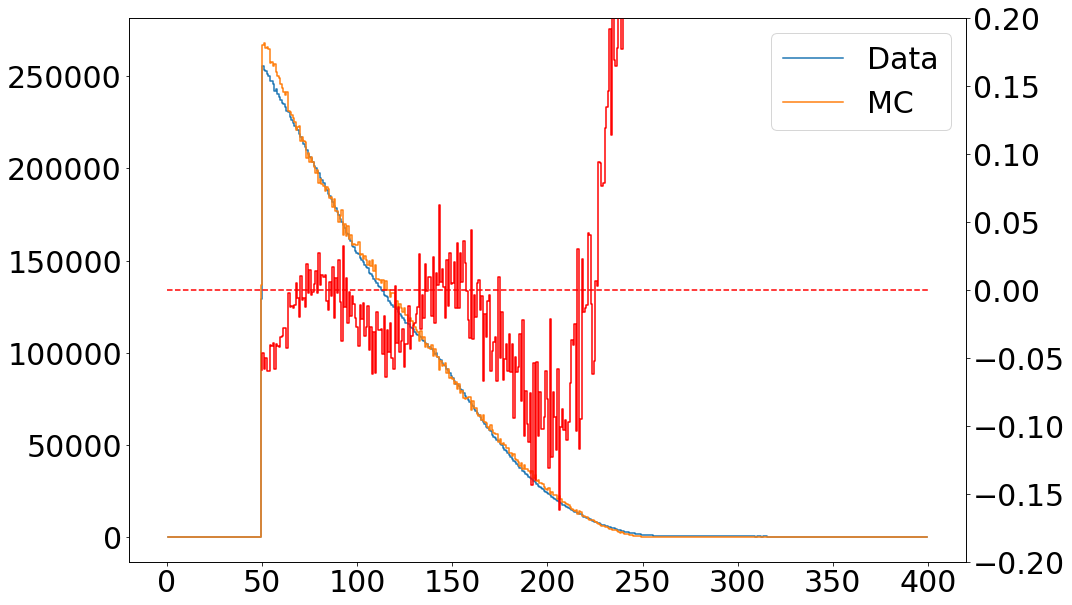

In [32]:
print(len(d))
d=d.view(recarray)
fs=30
figure(figsize=(15,10))
trutharray = np.sqrt(np.sum(d.osc_amps[:,0:2]**2.,axis=1)) < 50 #OSC AMP CUT
h,b=histogram(d.energy[trutharray],bins=500,range=[0,400])
sh,b=histogram(sb0.energy,bins=500,range=[0,400])
b=pd.cbins(b)

h,sh=h.astype(float),sh.astype(float)
norm=max(h[b>70])/max(sh[b>70])
plot(b,h,ds='steps',label='Data')
plot(b,sh*norm,ds='steps',label='MC')
tick_params(labelsize=fs)
legend(fontsize=fs)

twinx()
trutharray=(sh>0)*(h>0)
plot(b[trutharray],(h-sh*norm)[trutharray]/h[trutharray],color='r',ds='steps')
plot((0,400),(0,0),'r--')
ylim(-0.2,0.2)

tick_params(labelsize=fs)
show()

[19.4278580436755, 19.98029674788015]


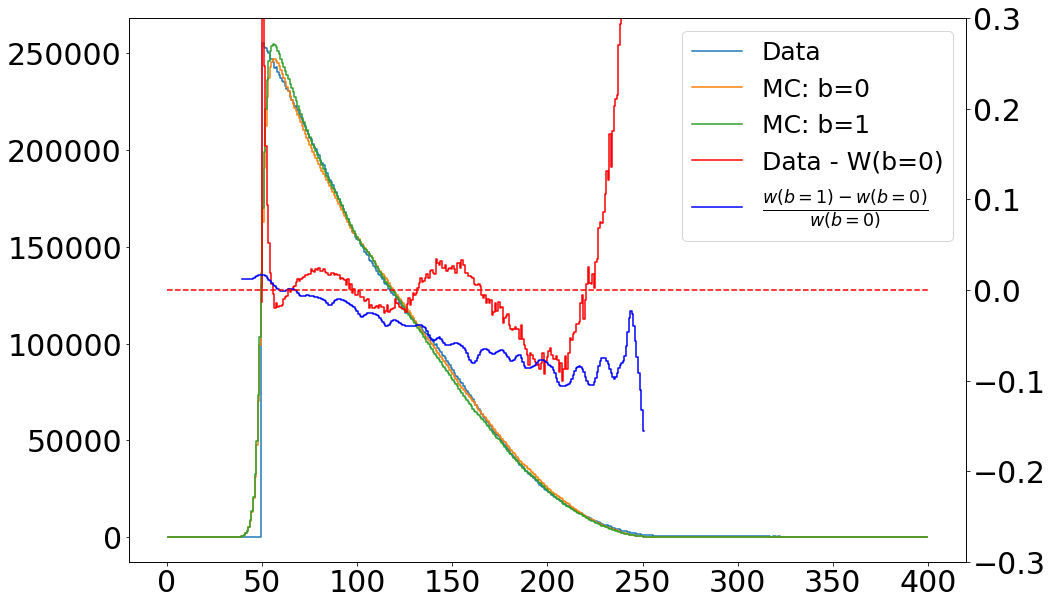

In [37]:
with open('/home/noah/Desktop/large_analysis/ca_analysis/detector_response/detector_response.pickle','rb') as f:
    detector_response=pickle.load(f)
bdchs=[35,11,12]

sh,b=histogram([],bins=500,range=[0,400])
b=pd.cbins(b)
sh=[zeros_like(b),zeros_like(b)]
for bdch in bdchs:
    bd,ch=int(bdch/8),int(bdch%8)
    sigma=detector_response[bdch]
    mu=400
    trutharray=(sb0.board==bd)*(sb0.channel==ch)
    temp=histogram(sb0.energy[trutharray],bins=500,range=[0,400])[0]
    temp=fftconvolve(temp,pd.gauss(b,mu=mu,sigma=sigma))[mu:mu+len(b)]
    sh[0]+=temp
    trutharray=(sb1.board==bd)*(sb1.channel==ch)
    temp=histogram(sb1.energy[trutharray],bins=500,range=[0,400])[0].astype(float)
#     trutharray=(sb0.board==bd)*(sb0.channel==ch)
#     temp=histogram(sb0.energy[trutharray],bins=500,range=[0,400])[0]
    temp=fftconvolve(temp,pd.gauss(b,mu=mu,sigma=sigma))[mu:mu+len(b)]
    sh[1]+=temp

    
figure(figsize=(15,10))
norm=[sum(h[b>00])/sum(sh[0][b>00]),sum(h[b>00])/sum(sh[1][b>00])]
print(norm)
l=[]
x,=plot(b,h,ds='steps',label='Data')
l.append(x)
x,=plot(b,sh[0]*norm[0],ds='steps',label='MC: b=0')
l.append(x)
# plot(b,sh[1]*norm[1],ds='steps',label='MC: b=1')
x,=plot(b,sh[1]*norm[1],ds='steps',label='MC: b=1')
l.append(x)
tick_params(labelsize=fs)

twinx()
trutharray=(sh[0]>0)*(h>0)
x,=plot(b[trutharray],(h-sh[0]*norm[0])[trutharray]/h[trutharray],color='r',ds='steps',label='Data - W(b=0)')
l.append(x)
trutharray=(sh[0]>10)*(sh[1]>10)
x,=plot(b[trutharray],(b0b1_norm*sh[1]-sh[0])[trutharray]*norm[1]/norm[0]/sh[0][trutharray],color='b',ds='steps',\
        label=r'$\frac{w(b=1)-w(b=0)}{w(b=0)}$')
l.append(x)
plot((0,400),(0,0),'r--')
ylim(-0.3,0.3)

legend(l,[lsub.get_label() for lsub in l],fontsize=fs-5)

tick_params(labelsize=fs)
show()

### We're fitting Orange + b*(Green-Orange) to Data
___
___
___

#### * sh = [convolved w(b=0), convolved w(b=1) ] 
#### * normalization is b0b1_norm= sum(w(b=0))/sum(w(b=1))
Now need to fit N*(sh[0] + b*(b0b1_norm*sh[1] - sh[0])) to data

h is data

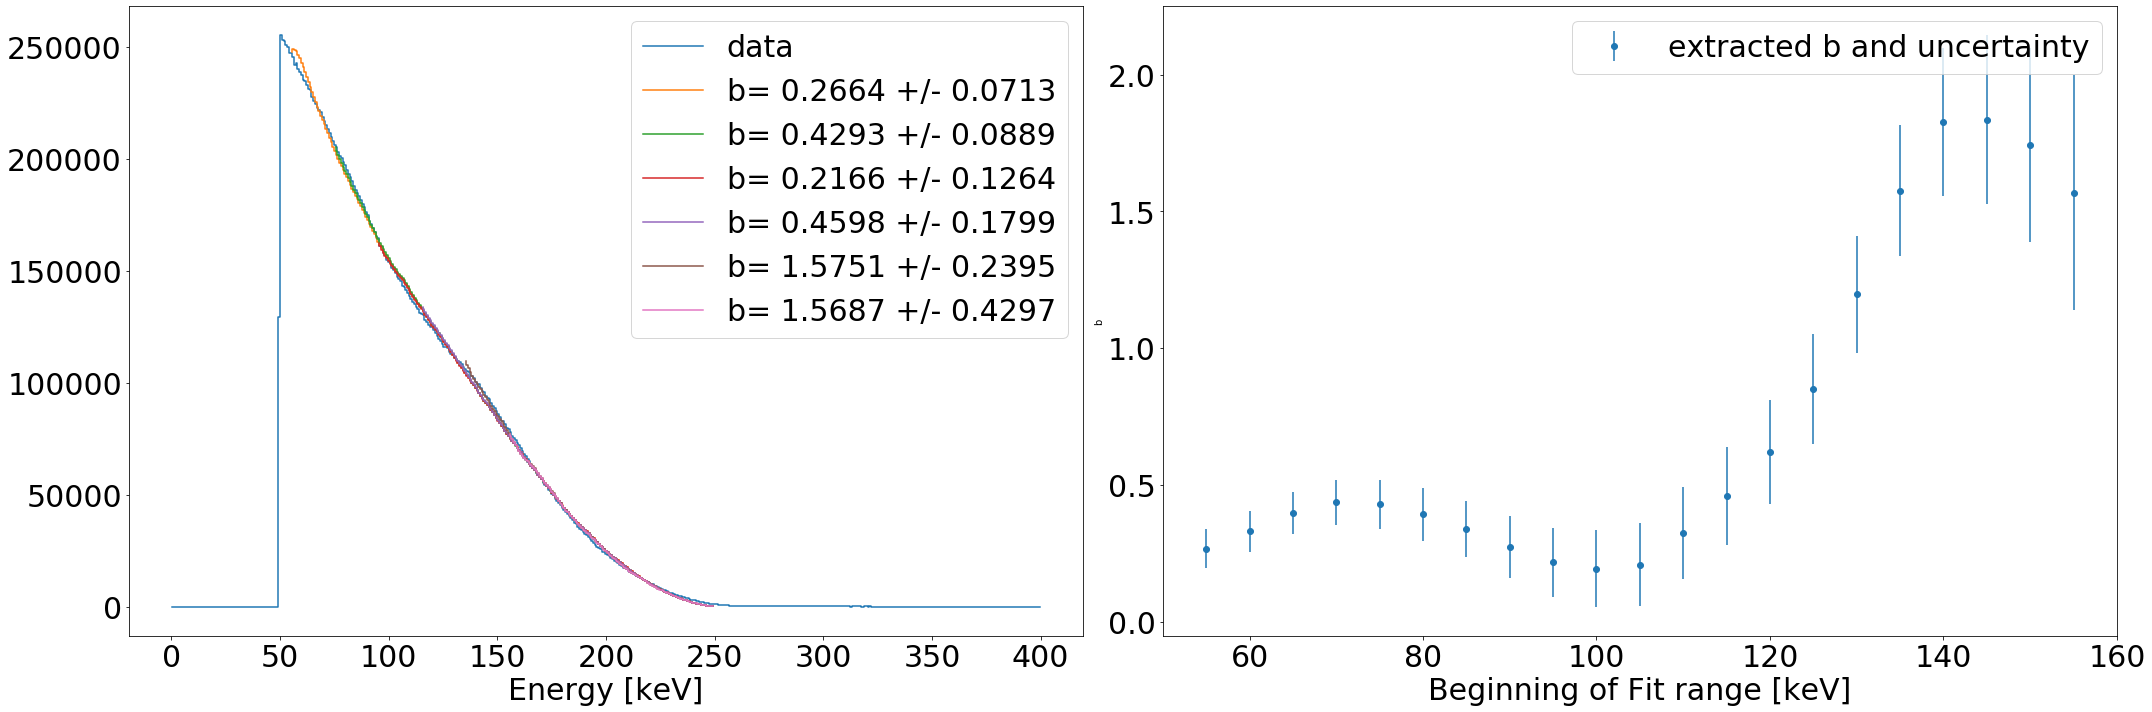

In [40]:
fig,ax= subplots(ncols=2,nrows=1,figsize=(30,10))
ax[0].plot(b,h,ds='steps',label='data')

bs=[]
sigs=[]

beg,end=80,250
steps=arange(55,160,5)
for i,beg in enumerate(steps):
    trutharray=(b>beg)*(b<end)
    weights=np.sqrt(h[trutharray])
    X=(trutharray,sh[0],b0b1_norm*sh[1])
    # print(X[0])
    pars,vrs=curve_fit(fierz_fit,X,h[trutharray],p0=[h[trutharray][0],0],sigma=weights)
    vrs=np.sqrt(np.diag(vrs))
    bs.append(pars[1]),sigs.append(vrs[1])
    if i%4 ==0:
        ax[0].plot(b[trutharray],fierz_fit(X,*pars),ds='steps',label='b= {:0.4f} +/- {:0.4f}'.format(pars[1],vrs[1]))

ax[0].tick_params(labelsize=fs)
ax[0].set_xlabel('Energy [keV]',fontsize=fs)
ax[0].legend(fontsize=fs)

ax[1].errorbar(steps,bs,sigs,fmt='o',label='extracted b and uncertainty')
ax[1].set_xlabel('Beginning of Fit range [keV]',fontsize=fs)
ax[1].set_ylabel('b')
ax[1].tick_params(labelsize=fs)
ax[1].legend(fontsize=fs)
tight_layout()
show()

# 100 keV fit width with a sliding beginning bin

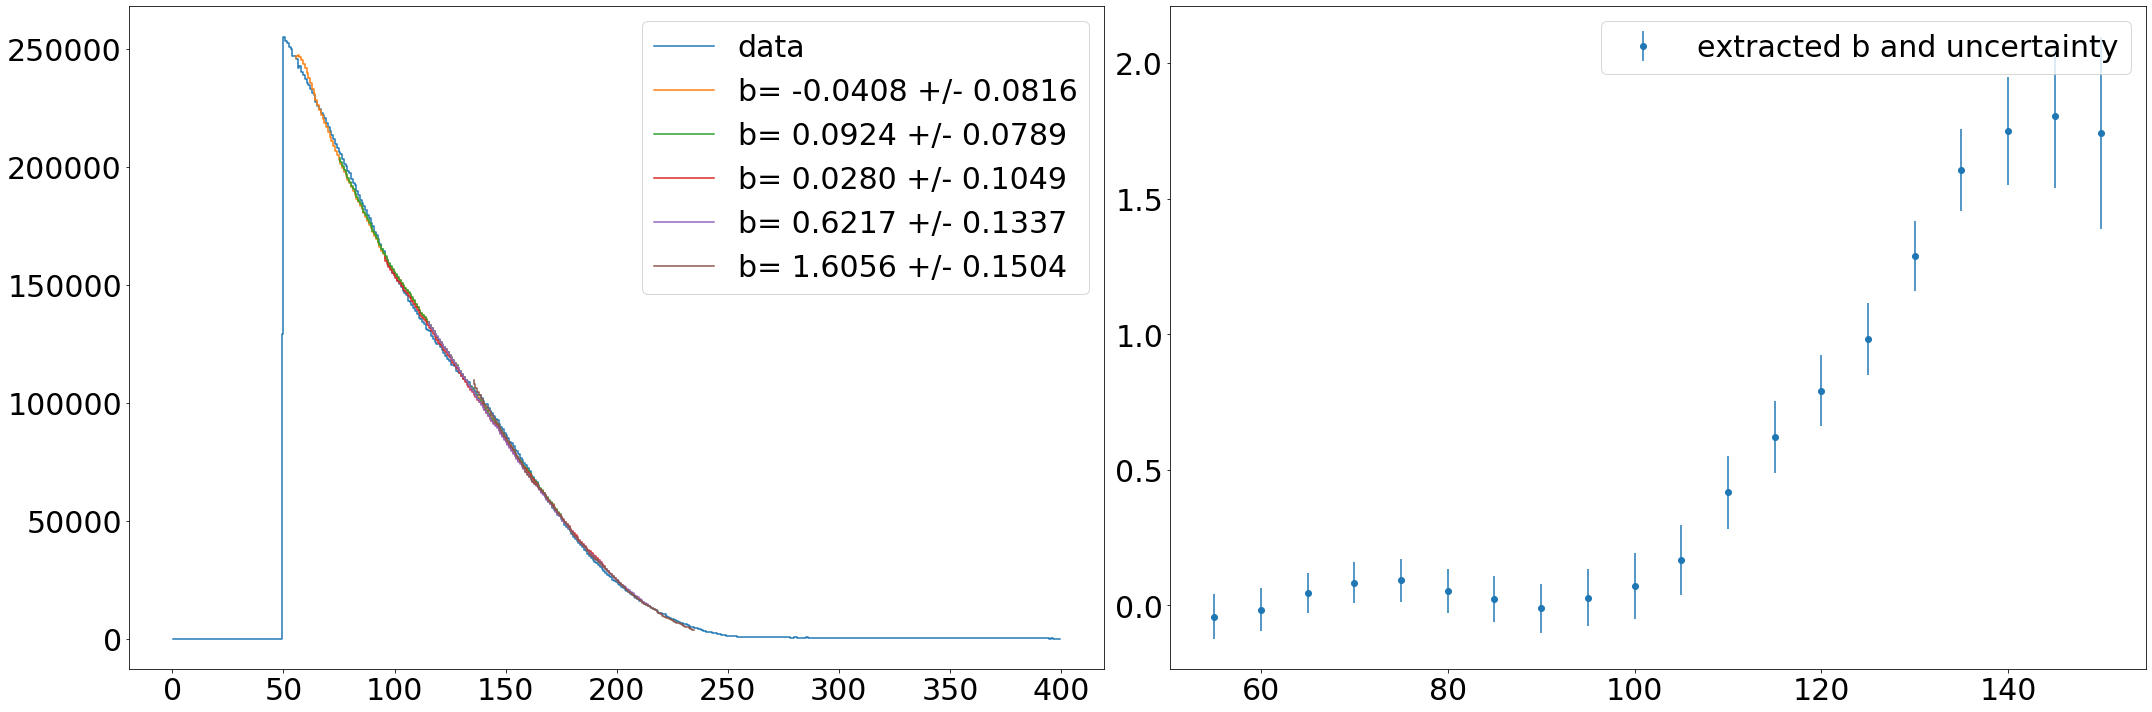

In [35]:
fig,ax= subplots(ncols=2,nrows=1,figsize=(30,10))
ax[0].plot(b,h,ds='steps',label='data')

bs=[]
sigs=[]

beg,end=50,150
steps=arange(5,105,5)
for i,step in enumerate(steps):
    beg=50+step; end=150+step
    trutharray=(b>beg)*(b<end)
    weights=np.sqrt(h[trutharray])
    X=(trutharray,sh[0],b0b1_norm*sh[1])
    # print(X[0])
    pars,vrs=curve_fit(fierz_fit,X,h[trutharray],p0=[h[trutharray][0],0],sigma=weights)
    vrs=np.sqrt(np.diag(vrs))
    bs.append(pars[1]),sigs.append(vrs[1])
    if i%4 ==0: 
        ax[0].plot(b[trutharray],fierz_fit(X,*pars),ds='steps',label='b= {:0.4f} +/- {:0.4f}'.format(pars[1],vrs[1]))

ax[0].tick_params(labelsize=fs)
ax[0].legend(fontsize=fs)

ax[1].errorbar(50+steps,bs,sigs,fmt='o',label='extracted b and uncertainty')
ax[1].tick_params(labelsize=fs)
ax[1].legend(fontsize=fs)
tight_layout()
show()